# Optimization Experiment

In [ ]:
import gc
import json
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings
from .ntsp_optimization import *

root_path = Path(Path().resolve()).parent.parent

warnings.filterwarnings('ignore')
mpl.style.use('ggplot')
sns.set(style="whitegrid")

experiment_path = root_path / "modules/experiments/ntsp_optimization"
res_path = experiment_path / "results"
res_dir = Path().parent / "ntsp_optimization/results"
ratio_df = load_ratio_dataframe(res_path, load=True)
iterations_df = load_iterations_df(res_path, compute=False)
main_c = "#8A1A8C"
second_c = "#1B998B"
third_c = "#FFA64C"
forth_c = "#DDEDAA"
my_gray = "#838383"
custom_palette = [main_c, second_c, third_c, forth_c]

Elaborating results in gs_40_13
Elaborating results in gs_35_41
Elaborating results in gs_20_14
Elaborating results in gs_35_44
Elaborating results in gs_50_33
Elaborating results in gs_35_47
Elaborating results in gs_50_25
Elaborating results in gs_50_4
Elaborating results in gs_35_33
Elaborating results in gs_25_6
Elaborating results in gs_30_12
Elaborating results in gs_30_37
Elaborating results in gs_35_21
Elaborating results in gs_35_6
Elaborating results in gs_40_10
Elaborating results in gs_20_47
Elaborating results in gs_30_7
Elaborating results in gs_30_21
Elaborating results in gs_20_33
Elaborating results in gs_30_13
Elaborating results in gs_35_18
Elaborating results in gs_35_3
Elaborating results in gs_30_23
Elaborating results in gs_30_16
Elaborating results in gs_25_24
Elaborating results in gs_50_2
Elaborating results in gs_30_20
Elaborating results in gs_30_35
Elaborating results in gs_30_46
Elaborating results in gs_50_46
Elaborating results in gs_35_35
Elaborating re

## Results Analysis

In [2]:
tmp_df = filter_iterations_df(
    iterations_df,
    {"circuit_depth": [(0, ">")]}
)
tmp_df["circuit_depth"].agg(
    ['sum', 'mean', 'median', 'std', 'count', lambda x: x.unique()])

sum                                               154500
mean                                            22.29759
median                                              24.0
std                                             3.598345
count                                               6929
<lambda>    [26, 25, 23, 22, 18, 19, 24, 20, 17, 21, 16]
Name: circuit_depth, dtype: object

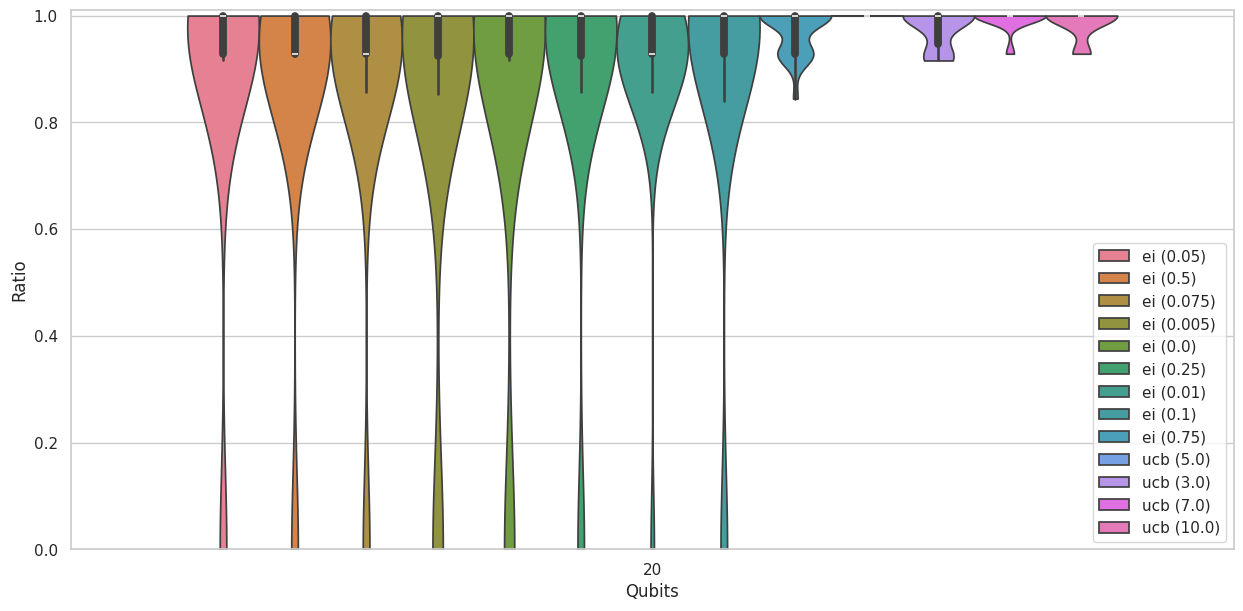

In [3]:
df = filter_ratio_df(
    ratio_df,
    {
        "Iterations": [(300, "<=")],
        "Qubits": [(50, "<")],
        "Shots": [([1000], "in")],
    }
)
df_queen = df[df["Optimizer"] == "QUEEN"]
plt.figure(figsize=(15, 7))
df_queen_20 = df_queen[df_queen["Qubits"] == 20]
sns.violinplot(data=df_queen_20, x="Qubits", y="Ratio", hue="Params", cut=0)
plt.ylim(min(df_queen_20["Ratio"] * 0.9), 1.01)
plt.legend(loc="lower right")
plt.savefig(res_dir / "scatter_ratio.pdf")

In [20]:
ratio_df["Shots"].unique()

array([ 3000,     0,   100,  5000, 10000,  1000,   500,  2260,  3600,
          50,  3085,   940,     5,  1510,  2255,  2000])

Optimizer
Q-INSP     250
SAMPLER    250
QTSA        28
Name: count, dtype: int64

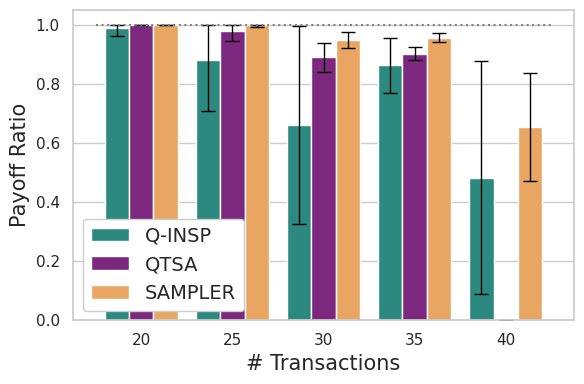

In [ ]:
custom_palette = [second_c, main_c, third_c, forth_c]
df = filter_ratio_df(
    ratio_df,
    {
        "Iterations": [(300, "<=")],
        "Qubits": [(50, "<")],
        "Shots": [([940, 1510, 2255, 3085, 3600, 10000], "in")],
        "Params": [(["-", "ucb (2.576)"], "in")]
    }
)
df['Optimizer'] = df.apply(sampler_decorator, axis=1)
plt.figure(figsize=(6, 4))
dfn = df[df["Optimizer"] != "SAMPLER (10000)"]
dfn = dfn[(dfn["Hammered"] == True) | (dfn["Optimizer"] != "MBD")]
df_no_cplex = dfn[dfn["Optimizer"] != "CPLEX"]
df_no_cplex.replace(
    {
        "SAMPLER (940)": "SAMPLER",
        "SAMPLER (1510)": "SAMPLER",
        "SAMPLER (2255)": "SAMPLER",
        "SAMPLER (3085)": "SAMPLER",
        "SAMPLER (3600)": "SAMPLER"
    },
    inplace=True)
df_no_cplex.replace({"MBD": "QTSA"}, inplace=True)
df_no_cplex.replace({"QUEEN": "Q-INSP"}, inplace=True)
summary = df_no_cplex.groupby(['Qubits', 'Optimizer'])['Ratio'].agg(
    ['mean', 'std']).reset_index()
barplot = sns.barplot(data=summary, x='Qubits', y='mean', hue='Optimizer',
                      ci=None, palette=custom_palette)
n_bars = len(summary['Optimizer'].unique())
n_groups = len(summary['Qubits'].unique())
for i, optimizer in enumerate(summary['Optimizer'].unique()):
    # Filter data for current optimizer
    mask = summary['Optimizer'] == optimizer
    means = summary[mask]['mean']
    stds = summary[mask]['std']
    indices = np.arange(n_groups)
    width = barplot.patches[0].get_width()
    offset = (i - (n_bars - 1) / 2) * width
    lower_errors = np.minimum(means,
                              stds)  # Prevent error bars from going below 0
    upper_errors = np.minimum(1 - means, stds)
    plt.errorbar(
        x=indices + offset,
        y=means,
        yerr=[lower_errors, upper_errors],  # Asymmetric errors: [lower, upper]
        fmt='none',
        c='black',
        capsize=5,
        elinewidth=1,
        clip_on=True  # Ensure bars are clipped at plot boundaries
    )
plt.hlines(y=1, xmin=-0.5, xmax=4.5, linestyle=":", color=my_gray)
plt.ylabel("Payoff Ratio", fontsize=15)
plt.xlabel("# Transactions", fontsize=15)
handles, labels = plt.gca().get_legend_handles_labels()
sorted_labels_and_handles = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_labels_and_handles)
plt.legend(sorted_handles, sorted_labels, loc="lower left", framealpha=1,
           fontsize=14)
plt.tight_layout()
plt.savefig(res_dir / "ratio_box.pdf")
plt.savefig(res_dir / "ratio_box.png", dpi=600)
# plt.show()
df_no_cplex["Optimizer"].value_counts()

In [23]:
df_no_cplex[df_no_cplex["Optimizer"] == "SAMPLER"]

,Optimizer,Qubits,Payoff,Ratio,Shots,Iterations,Repetition,Sparsity,Hammered,Minimizer,Params,Max_Payoff
9,SAMPLER,40,0.369256,0.525073,3600,300,13,0,False,-,-,0.703248
18,SAMPLER,35,0.801489,0.969245,3085,300,41,0,False,-,-,0.826921
39,SAMPLER,20,0.999974,1.000000,940,300,14,0,False,-,-,0.999974
45,SAMPLER,35,0.798984,0.966216,3085,300,44,0,False,-,-,0.826921
65,SAMPLER,35,0.775919,0.938322,3085,300,47,0,False,-,-,0.826921
...,...,...,...,...,...,...,...,...,...,...,...,...
3472,SAMPLER,30,0.948983,0.948999,2255,300,9,0,False,-,-,0.999983
3482,SAMPLER,40,0.599535,0.852523,3600,300,30,0,False,-,-,0.703248
3485,SAMPLER,35,0.776698,0.939265,3085,300,12,0,False,-,-,0.826921
3525,SAMPLER,40,0.525106,0.746687,3600,300,36,0,False,-,-,0.703248


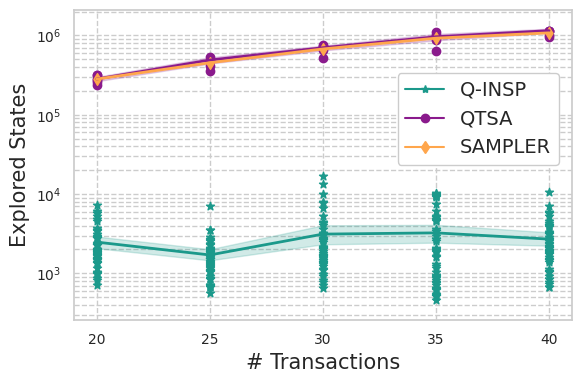

In [16]:
import matplotlib.lines as mlines

plt.figure(figsize=(6, 4))
aggregated_df = filter_iterations_df(
    df=iterations_df,
    filter_dict={
        "minimizer_params": [("ucb (2.576)", "==")],
        "qubits": [(50, "<")],
        "iteration": [(300, "==")],
        "shots": [(10000, "==")]
    }
)

sns.lineplot(data=aggregated_df, x="qubits", y="explored_states",
             hue="optimizer", palette=[second_c, main_c], linewidth=2)
aggregated_df_queen = aggregated_df[aggregated_df["optimizer"] == "QUEEN"]
aggregated_df_mbd = aggregated_df[
    (aggregated_df["optimizer"] == "MBD") & (aggregated_df["raw_counts"] != 0)]
plt.scatter(x=aggregated_df_queen["qubits"],
            y=aggregated_df_queen["explored_states"], marker="*",
            color=second_c)
plt.scatter(x=aggregated_df_mbd["qubits"],
            y=aggregated_df_mbd["explored_states"], marker="o", color=main_c)
sizes = aggregated_df_queen["qubits"].unique()
sizes = sorted(sizes)
plt.plot(sizes, [282000, 453000, 676500, 925500, 1080000], color=third_c, label="SAMPLER", lw=2)
plt.scatter(y=[282000, 453000, 676500, 925500, 1080000], x=sizes, color=third_c, marker="d",
            label="SAMPLER")

#plt.plot([s for s in sizes], [2**i for i in sizes], color=my_gray, marker="s", label="LIMIT", lw=2)
plt.ylabel("Explored States", fontsize=15)
plt.xlabel("# Transactions", fontsize=15)
plt.yscale('log')
plt.xticks(sorted(aggregated_df["qubits"].unique()))
#plt.minorticks_on()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
sorted_labels_and_handles = sorted(zip(labels, handles), key=lambda x: x[0])
sorted_labels, sorted_handles = zip(*sorted_labels_and_handles)
handles = [
    mlines.Line2D([], [], color=second_c, marker="*", label='Q-INSP'),
    mlines.Line2D([], [], color=main_c, marker="o", label='QTSA'),
    mlines.Line2D([], [], color=third_c, marker="d", label='SAMPLER'),
    # mlines.Line2D([], [], color=my_gray, marker="s", label=r'$2^{|\mathbb{T}~|}$'),
]
plt.legend(handles=handles, title="", fontsize=14, loc=(0.65, 0.5),
           framealpha=1)
plt.xticks(plt.xticks()[0], fontsize=10)
plt.yticks(plt.yticks()[0], fontsize=10)
plt.ylim(2 ** 8, 2 ** 21)
plt.savefig(res_dir / "explored_states.pdf")
plt.savefig(res_dir / "explored_states.png", dpi=600)
plt.show()

In [10]:
print("Average points:")
for size in aggregated_df_mbd["qubits"].unique():
    avg_df = aggregated_df_mbd[aggregated_df_mbd["qubits"] == size]
    print()
    print(size)
    print(np.average(avg_df["explored_states"]))
    print(np.average(avg_df["explored_states"]) / 300)

Average points:

35
925036.6666666666
3083.4555555555553

40
1080488.8
3601.6293333333333

30
676731.3333333334
2255.771111111111

20
281778.1666666667
939.2605555555556

25
453517.4
1511.7246666666667


,Unnamed: 0,file,backend_name,optimizer,shots,circuit,qubits,repetition,iteration,explored_states,...,raw_counts,hammered_count,q_time,circuit_depth,cplex_payoff,cplex_solution,minimizer,minimizer_params,old_params,new_params
300,300,gs_40_13/quantum_2024-09-18_21-17-25,-,QUEEN,10000,rotations,40,13,300,682,...,0,1,-1.0,-1,0.703248,[1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0...,BAYESIAN,ucb (2.576),3.141592653589793 0.0 0.0 3.141592653589793 3....,3.141592653589793 0.0 0.0 3.141592653589793 3....
601,601,gs_35_41/quantum_2024-09-19_09-56-03,-,QUEEN,10000,rotations,35,41,300,630,...,0,1,-1.0,-1,0.826921,[1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1...,BAYESIAN,ucb (2.576),3.141592653589793 3.141592653589793 0.0 0.0 0....,3.141592653589793 3.141592653589793 0.0 0.0 0....
3611,3611,gs_20_14/quantum_2024-09-18_21-24-27,-,QUEEN,10000,rotations,20,14,300,1896,...,0,1,-1.0,-1,0.999974,[1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1],BAYESIAN,ucb (2.576),3.141592653589793 0.0 0.0 3.141592653589793 3....,3.1415767041157228 0.0 0.0 3.1415767041157228 ...
3912,3912,gs_35_44/quantum_2024-09-19_10-50-57,-,QUEEN,10000,rotations,35,44,300,9350,...,0,142,-1.0,-1,0.826921,[1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1...,BAYESIAN,ucb (2.576),0.0 1.888020286874005 0.0 1.59212556895399 3.1...,0.0 3.0171128050715614 0.0 1.7183527938198226 ...
4514,4514,gs_35_47/quantum_2024-09-19_11-39-21,-,QUEEN,10000,rotations,35,47,300,632,...,0,1,-1.0,-1,0.826921,[1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1...,BAYESIAN,ucb (2.576),3.141592653589793 0.0 0.0 0.0 3.14159265358979...,3.141592653589793 0.0 0.0 0.0 3.14159265358979...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209806,209806,gs_30_9/quantum_2024-09-18_21-34-40,-,QUEEN,10000,rotations,30,9,300,1096,...,0,1,-1.0,-1,0.999983,[1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0...,BAYESIAN,ucb (2.576),3.141592653589793 0.6537546747408415 0.0 3.141...,3.141592653589224 3.4551408277128104e-05 0.0 3...
210107,210107,gs_40_30/quantum_2024-09-19_12-01-21,-,QUEEN,10000,rotations,40,30,300,1734,...,0,1,-1.0,-1,0.703248,[1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0...,BAYESIAN,ucb (2.576),3.141592653589793 3.141592653589793 0.0 3.1415...,3.141592653589793 3.141592653589793 0.0 3.1415...
210408,210408,gs_35_12/quantum_2024-09-18_23-19-44,-,QUEEN,10000,rotations,35,12,300,522,...,0,1,-1.0,-1,0.826921,[1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1...,BAYESIAN,ucb (2.576),3.141592653589793 0.0 0.0 0.0 3.14159265358979...,3.141592653589793 0.0 0.0 0.0 3.14159265358979...
211913,211913,gs_40_36/quantum_2024-09-19_14-39-50,-,QUEEN,10000,rotations,40,36,300,2064,...,0,1,-1.0,-1,0.703248,[1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0...,BAYESIAN,ucb (2.576),3.141592653589793 0.0 0.0 3.141592653589793 3....,3.141592653589793 0.0 0.0 3.141592653589793 3....


In [ ]:
def deserialize_json(cnf: dict, base: str) -> dict:
    current_dict = {}
    for key in cnf.keys():
        if isinstance(cnf[key], dict):
            sub_dict = deserialize_json(cnf[key], f"{key}_")
            for s_key in sub_dict.keys():
                current_dict[f"{base}{s_key}"] = sub_dict[s_key]
        else:
            current_dict[f"{base}{key}"] = cnf[key]
    return current_dict


def config_check(cfg: dict, key: str, default: str = "-") -> str:
    return str(cfg[key]).replace("_", "\_") if key in cfg.keys() else default


queen_vals = []
mbd_vals = []
for f in aggregated_df["file"].unique():
    with open(res_path / Path(f) / "config.json", "r") as f:
        config = json.load(f)
    dsr_config = deserialize_json(config, base="")
    mbd_vals.append(
        [
            config_check(dsr_config, "opt_mode"),
            # config_check(dsr_config, "instance")[:6],
            config_check(dsr_config,
                         "opt_options_primitive_options_backend_options_name"),
            config_check(dsr_config, "opt_options_ansatz"),
            config_check(dsr_config, "opt_options_shots"),
            config_check(dsr_config, "opt_options_minimizer"),
            config_check(dsr_config,
                         "opt_options_minimizer_options_maxiter"),
            #config_check(dsr_config, "opt_options_minimizer_options_sd")[:7],
            "-" != config_check(dsr_config,
                                "opt_options_primitive_options_mitigation_options_dd_sequence_type"),
            config_check(dsr_config,
                         "opt_options_primitive_options_mitigation_options_dd_sequence_type"),
            "-" != config_check(dsr_config,
                                "opt_options_primitive_options_mitigation_options_rem_hammer_max_hd"),
        ]
    )

mbd_config_df = pd.DataFrame(
    mbd_vals,
    columns=[
        "Solver",
        # "Instance",
        "Backend",
        "Ansatz",
        "Shots",
        "Acquisition Function",
        "Iterations",
        # "Std. Dev.",
        "DD",
        "DD Sequence",
        "iHAMMER"
    ]
)
mbd_config_df = mbd_config_df[(mbd_config_df["Solver"] != "MBD") | (mbd_config_df["iHAMMER"] != False)]
mbd_tmp_df = mbd_config_df.drop_duplicates()  # .sort_values(by="Instance", ascending=True)
f_dict = {}
values = [
        # "Instance",
        "Backend",
        "Ansatz",
        "Shots",
        "Acquisition Function",
        "Iterations",
        # "Std. Dev.",
        "DD",
        "DD Sequence",
        "iHAMMER"
    ]
for n, row in mbd_tmp_df.iterrows():
    key = f"{row['Solver']}_{n}"
    f_dict[key] = row[values]

f_df = pd.DataFrame(f_dict)
print(f_df.to_latex())

\begin{tabular}{lllll}
\toprule
 & QUEEN_0 & MBD_19 & MBD_48 & MBD_51 \\
\midrule
Backend & - & ibm\_brisbane & ibm\_sherbrooke & ibm\_fez \\
Ansatz & rotations & hardware\_efficient & hardware\_efficient & hardware\_efficient \\
Shots & 10000 & 10000 & 10000 & 10000 \\
Acquisition Function & BAYESIAN & BAYESIAN & BAYESIAN & BAYESIAN \\
Iterations & 300 & 300 & 300 & 1000 \\
DD & False & True & True & True \\
DD Sequence & - & XpXm & XpXm & XpXm \\
iHAMMER & False & True & True & True \\
\bottomrule
\end{tabular}



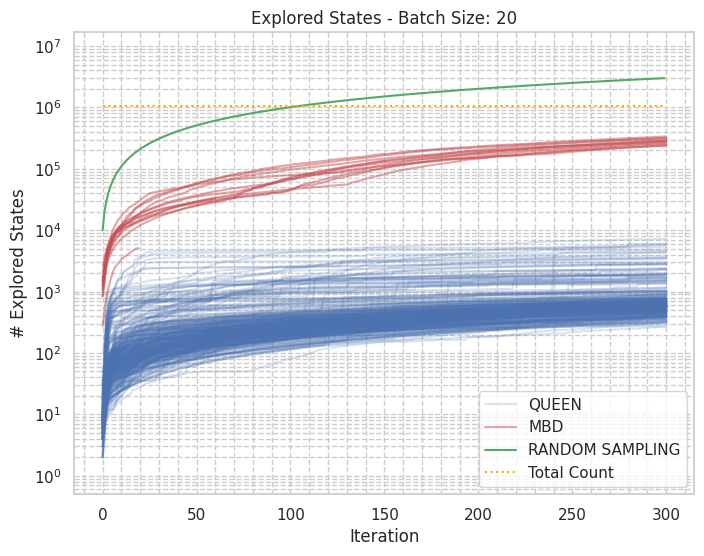

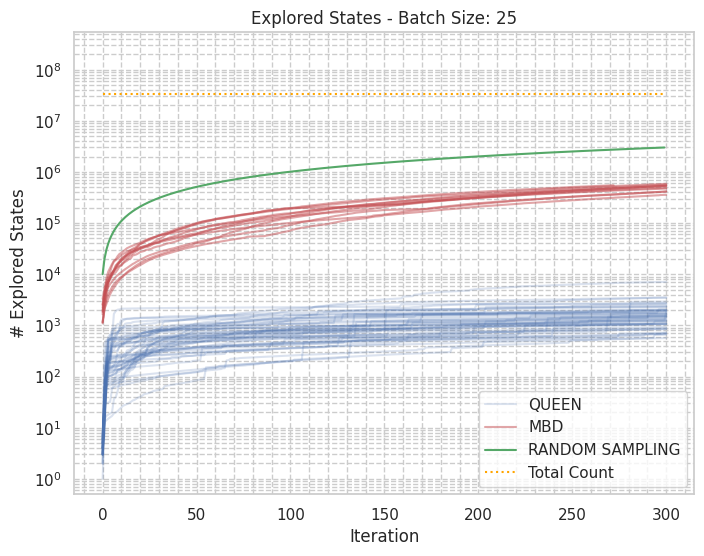

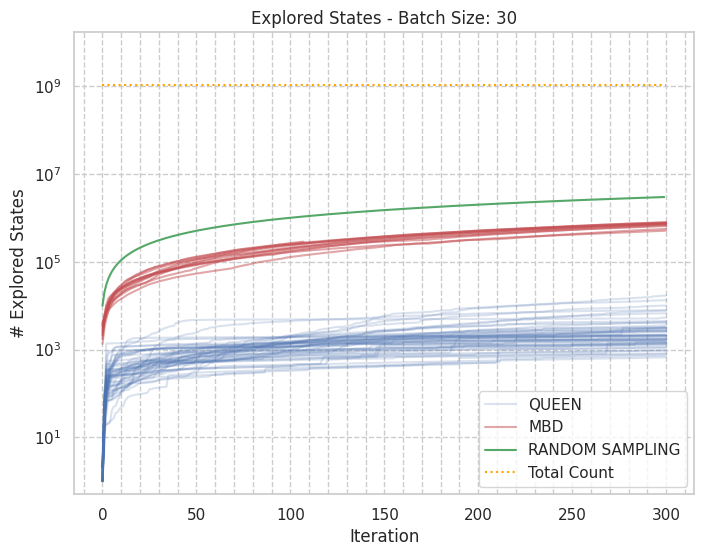

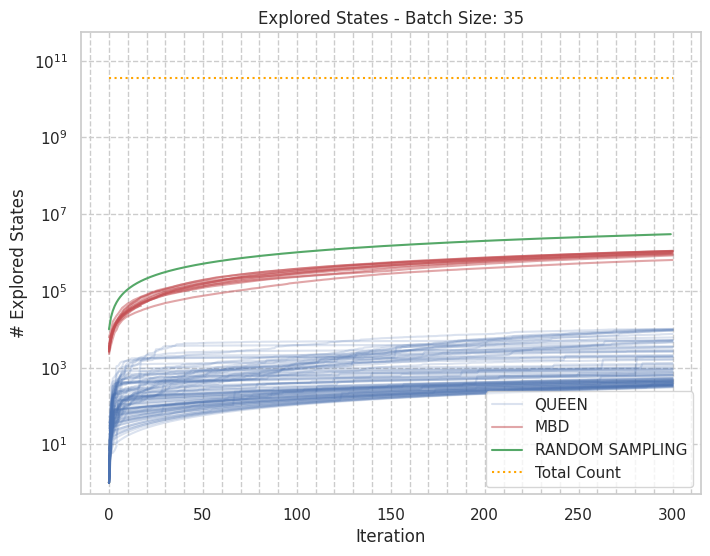

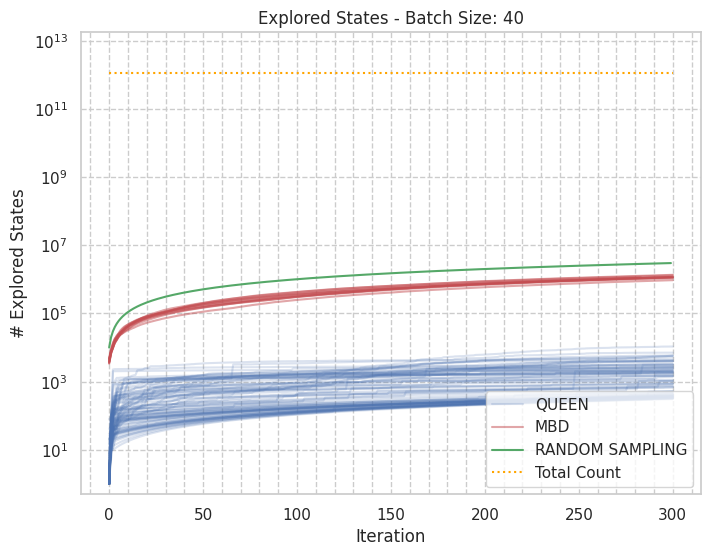

In [5]:
for size in [20, 25, 30, 35, 40]:
    df_size_queen = filter_iterations_df(
        df=iterations_df,
        filter_dict={
            "file": [("gs_40_0/quantum_2024-09-16_09-23-51", "!=")],
            "optimizer": [("QUEEN", "==")],
            "qubits": [(size, "==")],
        }
    )
    df_size_mbd = filter_iterations_df(
        df=iterations_df,
        filter_dict={
            "file": [("gs_40_0/quantum_2024-09-16_09-23-51", "!=")],
            "optimizer": [("MBD", "==")],
            "qubits": [(size, "==")],
        }
    )
    # Plot the lines by grouping by 'group'
    plt.figure(figsize=(8, 6))

    for n, (group, group_data) in enumerate(df_size_queen.groupby('file')):
        label = "QUEEN" if n == 0 else None
        plt.plot(group_data['iteration'], group_data['explored_states'],
                 color="b", alpha=0.2, label=label)

    for n, (group, group_data) in enumerate(df_size_mbd.groupby('file')):
        label = "MBD" if n == 0 else None
        plt.plot(group_data['iteration'], group_data['explored_states'],
                 color="r", alpha=0.5, label=label)

    plt.plot([i for i in range(300)], [(i + 1) * 10000 for i in range(300)],
             color="g", label="RANDOM SAMPLING")

    plt.hlines(
        y=2 ** size,
        linestyles=":",
        color="orange",
        xmin=min(min(df_size_mbd["iteration"]),
                 min(df_size_queen["iteration"])),
        xmax=max(max(df_size_mbd["iteration"]),
                 max(df_size_queen["iteration"])),
        label="Total Count"
    )

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('# Explored States')
    plt.ylim((0.5, max(2 ** (size + 4), 2 * 300 * 10000)))
    plt.title(f'Explored States - Batch Size: {size}')
    plt.legend(loc="lower right")
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid(True, which="both", ls="--")
    plt.savefig(res_path / f"{size}_exploration.pdf")
    # plt.show()

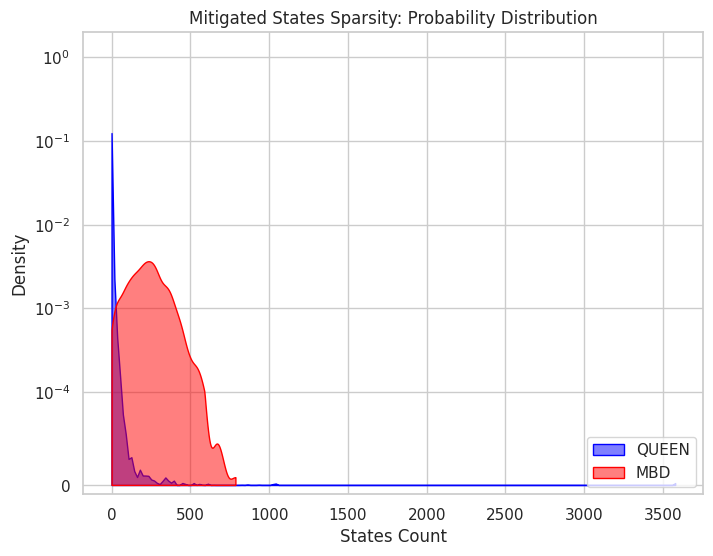

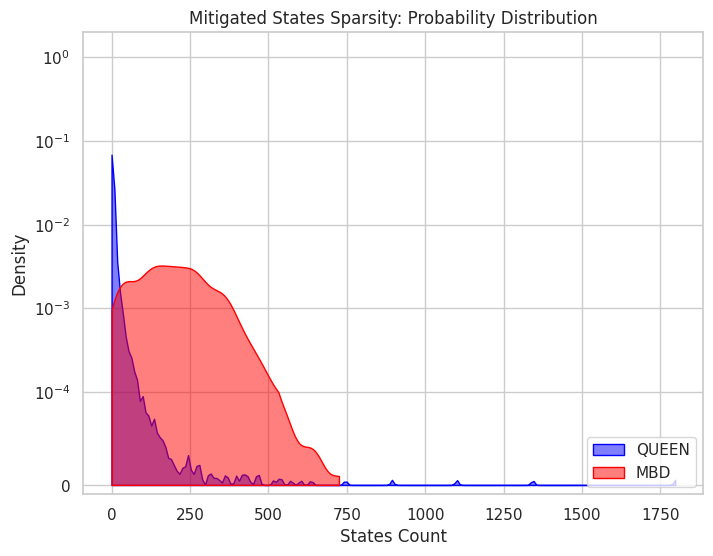

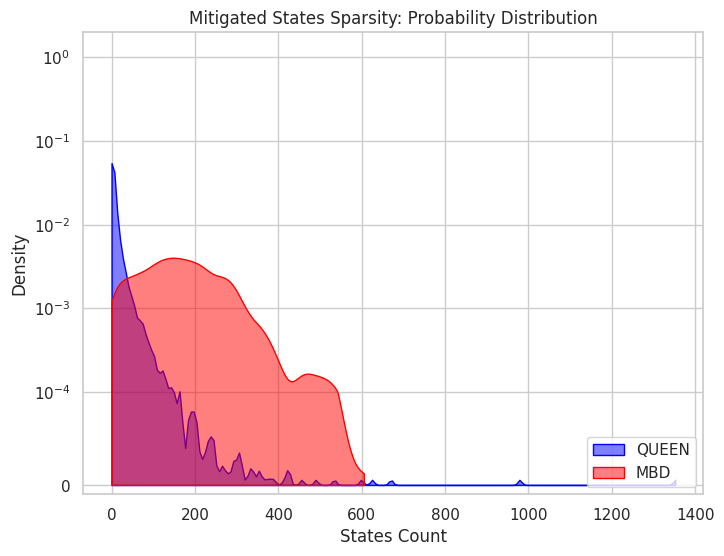

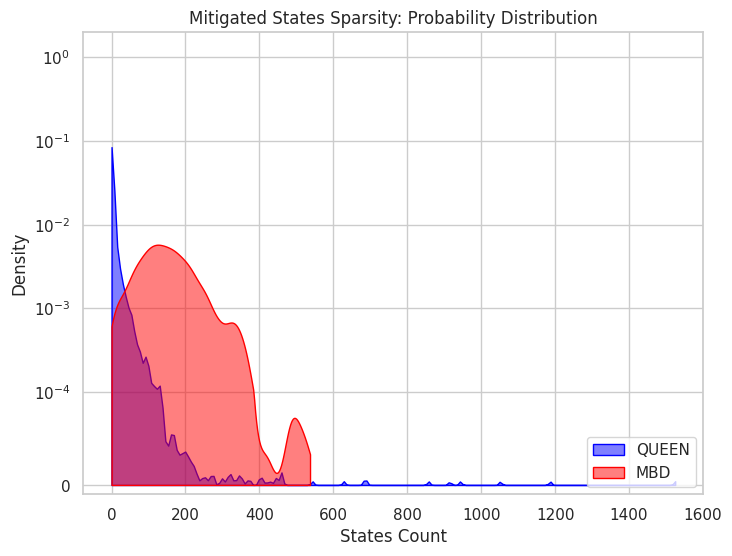

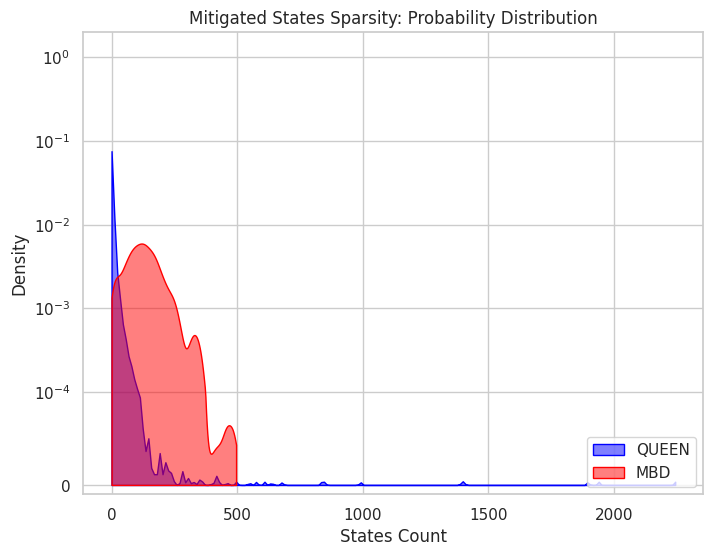

In [6]:
for size in [20, 25, 30, 35, 40]:
    df_size_queen = filter_iterations_df(
        df=iterations_df,
        filter_dict={
            "optimizer": [("QUEEN", "==")],
            "qubits": [(size, "==")],
        }
    )
    df_size_mbd = filter_iterations_df(
        df=iterations_df,
        filter_dict={
            "optimizer": [("MBD", "==")],
            "qubits": [(size, "==")],
            "raw_counts": [(1, ">=")],
        }
    )
    # Plot the lines by grouping by 'group'
    plt.figure(figsize=(8, 6))
    sns.kdeplot(df_size_queen["hammered_count"],
                clip=(0, max(df_size_queen["hammered_count"])),
                label='QUEEN',
                color='blue',
                fill=True,
                alpha=0.5)

    # Plot KDE for sample2
    sns.kdeplot(
        df_size_mbd["hammered_count"],
        clip=(0, max(df_size_mbd["hammered_count"])),
        label='MBD',
        color='red',
        fill=True,
        alpha=0.5)

    # Add labels and title
    plt.xlabel('States Count')
    plt.ylabel('Density')
    plt.title('Mitigated States Sparsity: Probability Distribution')
    plt.yscale("symlog", linthresh=10 ** -4)
    plt.ylim((-0.00001, 2))
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(res_path / f"{size}_mitigated_state.pdf")
    # plt.show()

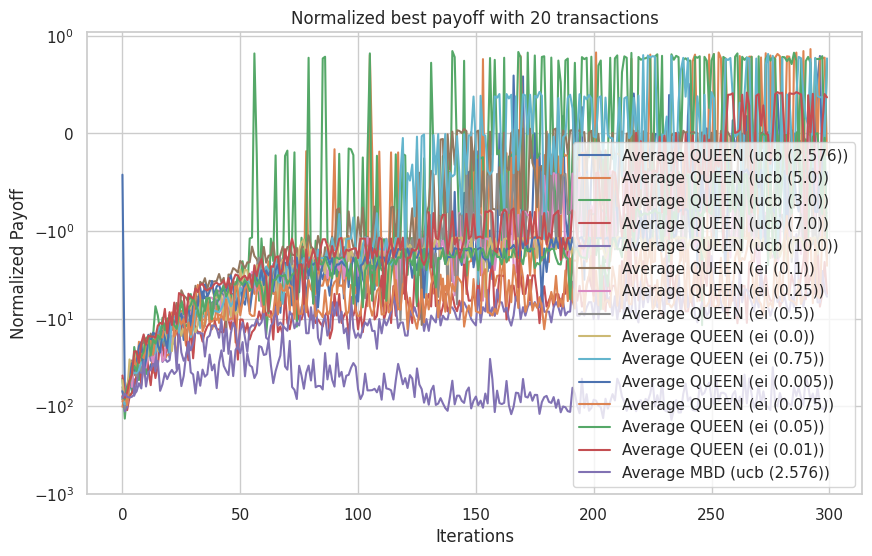

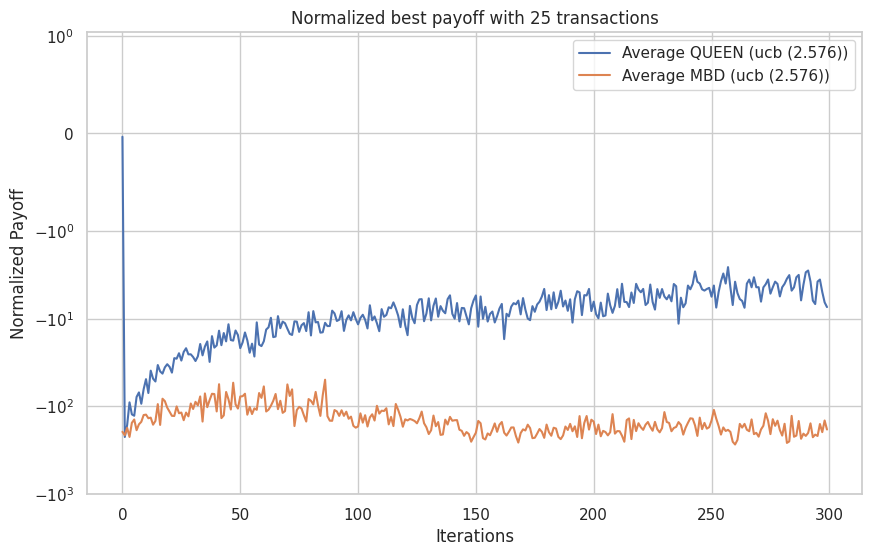

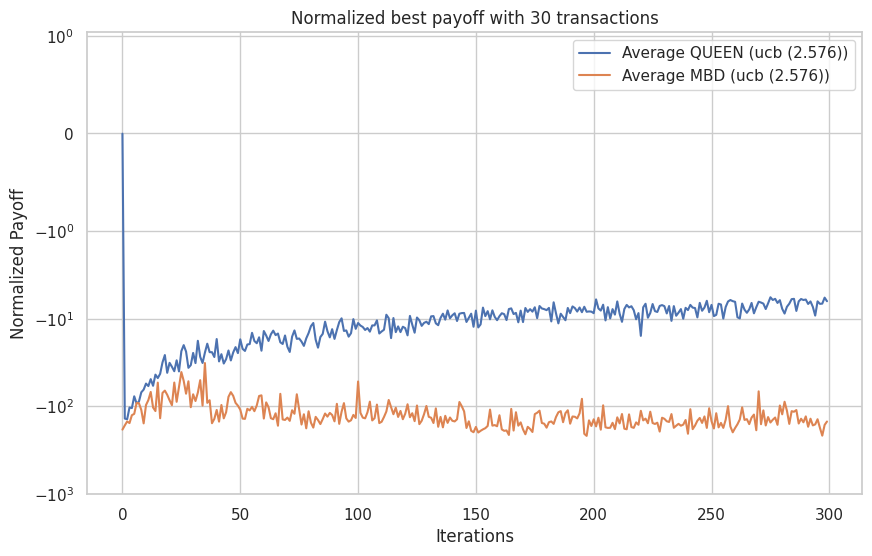

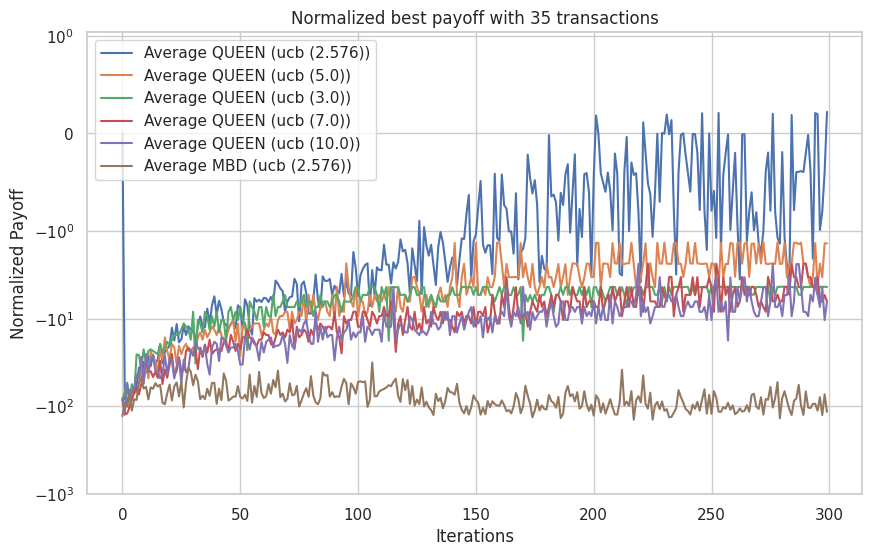

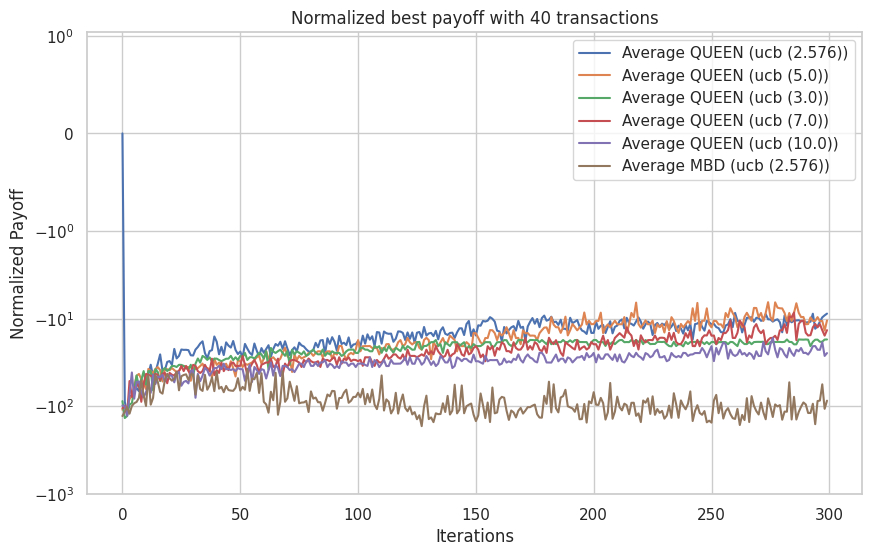

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


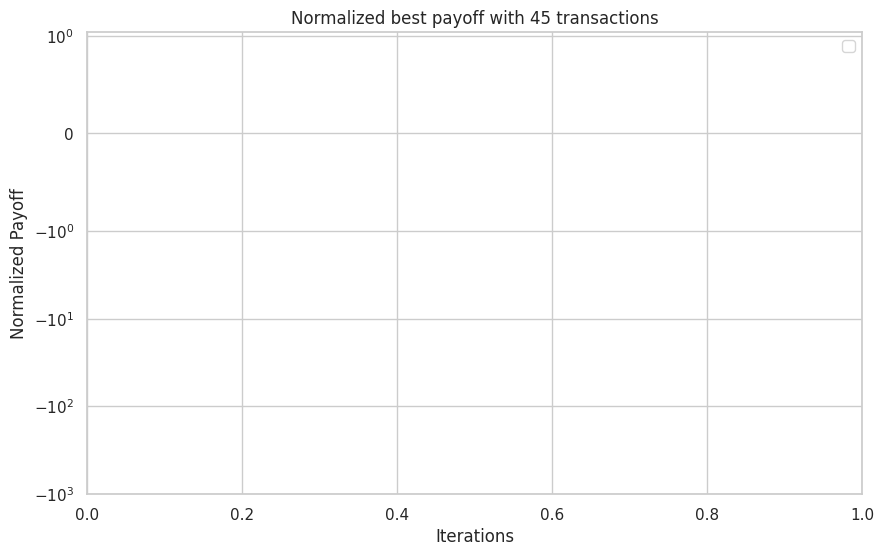

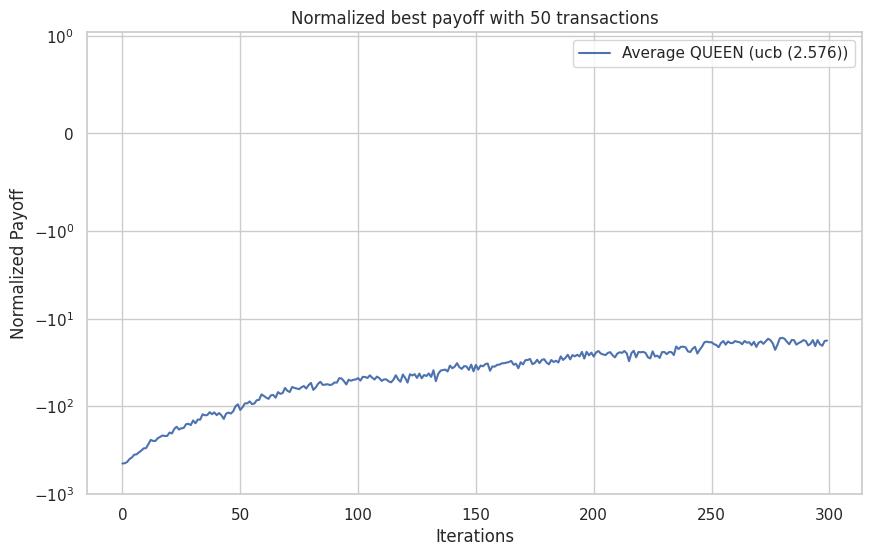

In [7]:
# Example usage
for Q in [20, 25, 30, 35, 40, 45, 50]:
    plt.figure(figsize=(10, 6))
    plot_avg_and_standard_dev(
        iterations_df,
        res_path,
        Q
    )

In [11]:
filtered_it_df = filter_iterations_df(
    iterations_df,
    {
        "minimizer_params": [("ei (0.75)", "==")],
        "qubits": [(20, "==")],
        "repetition": [(5, "<")],
        "shots": [(2000, "==")],
    }
)
filtered_it_df.columns
# for file_name in filtered_it_df["file"].unique():
#     iterations_df = iterations_df[iterations_df["file"] != file_name]
# iterations_df.to_csv(res_path / "iterations_df.csv")


Index(['Unnamed: 0', 'file', 'backend_name', 'optimizer', 'shots', 'circuit',
       'qubits', 'repetition', 'iteration', 'explored_states',
       'relevant_states', 'max_sample_probs', 'max_sample_payoff',
       'min_sample_payoff', 'valid_states', 'valid_states_probs',
       'max_hammered_payoff', 'min_hammered_payoff', 'valid_hammered',
       'valid_hammered_probs', 'best_solution', 'payoff_best', 'payoff',
       'raw_counts', 'hammered_count', 'q_time', 'circuit_depth',
       'cplex_payoff', 'cplex_solution', 'minimizer', 'minimizer_params',
       'old_params', 'new_params'],
      dtype='object')

In [ ]:
from matplotlib.lines import Line2D

QUEEN_it_df = filter_iterations_df(
    filtered_it_df,
    {"optimizer": [("QUEEN", "==")], }
)

EAGLE_it_df = filter_iterations_df(
    filtered_it_df,
    {"optimizer": [("MBD", "==")],
     "backend_name": [("ibm_brisbane", "==")],
     "raw_counts": [(0, "<=")], }
)

EAGLE_H_it_df = filter_iterations_df(
    filtered_it_df,
    {"optimizer": [("MBD", "==")],
     "backend_name": [("ibm_brisbane", "==")],
     "raw_counts": [(0, ">")], }
)

HERON_it_df = filter_iterations_df(
    filtered_it_df,
    {"optimizer": [("MBD", "==")],
     "backend_name": [("ibm_fez", "==")],
     "raw_counts": [(0, "<=")], }
)

HERON_H_it_df = filter_iterations_df(
    filtered_it_df,
    {"optimizer": [("MBD", "==")],
     "backend_name": [("ibm_fez", "==")],
     "raw_counts": [(0, ">")], }
)

df_list = [QUEEN_it_df, EAGLE_it_df, EAGLE_H_it_df, HERON_it_df, HERON_H_it_df]
files_list = ["gs_20_2/quantum_2024-10-31_11-57-26",
              "gs_20_0/quantum_2024-10-22_08-56-05",
              "gs_20_0/quantum_2024-10-22_08-55-13",
              "gs_20_1/quantum_2024-11-01_11-07-58",
              "gs_20_1/quantum_2024-11-01_11-06-59"]

fig, axs = plt.subplots(2, len(df_list),  # + 1,
                        figsize=(24, 8), gridspec_kw={
        'height_ratios': [4, 2]}, sharex=True)
# fig.set_facecolor('none')
fig.patch.set_alpha(0)

for n, df in enumerate(df_list):
    unique_files = df["file"].unique()
    params_dict = get_params_dict(res_path, unique_files)
    h = all(df["raw_counts"]) >= 1
    min_evs = 0
    df['payoff_best'] = -df['payoff_best']

    for nf, f in enumerate(unique_files):
        print(f"{f} {nf}/{len(unique_files)}")
        rep = f.split("/")[0].split("_")[2]
        size = f.split("/")[0].split("_")[1]
        file_df = df[df["file"] == f]
        df_sorted = file_df.sort_values(by='iteration')
        evs = df_sorted['payoff'].tolist()
        bests = (df_sorted['payoff_best']).tolist()
        if h:
            pb = 'valid_hammered_probs'
        else:
            pb = 'valid_states_probs'
        valids_probs = [float(v) if v != "[]" else 0 for v in
                        df_sorted[pb].tolist()]
        optimizer = file_df["optimizer"].unique()[0]

        if f == files_list[n]:
            alpha = 1
        else:
            alpha = 0.2
        axs[1][n].plot(range(len(evs)), valids_probs, color=third_c,
                       alpha=alpha, lw=2)
        num_iterations = len(evs)
        axs[0][n].plot(range(len(evs)), evs, label="Point Evaluation",
                       color=main_c, alpha=alpha, lw=2)
        axs[0][n].plot(range(len(evs)), bests, linestyle="--",
                       label="Best Solution", color=second_c, alpha=alpha, lw=2)
        min_evs = min(min_evs, min(evs))

    # base_df_sorted = avg_df = df[['iteration', 'payoff', 'payoff_best', pb]].groupby('iteration', as_index=False).mean().sort_values('iteration', ascending=False)
    # axs[0][n].plot(base_df_sorted["iteration"], base_df_sorted["payoff_best"], linestyle="--", color=second_c)
    # axs[0][n].plot(base_df_sorted["iteration"], base_df_sorted["payoff"], color=main_c)

    axs[0][n].hlines(0, 0, max(df["iteration"]),
                     linestyles=":", color=my_gray, label="Validity Threshold")
    axs[0][n].hlines(max(df["cplex_payoff"]), 0, max(df["iteration"]),
                     linestyles=":", color=my_gray, label="Optimal Payoff")
    axs[0][n].set_ylim(min_evs, 2)
    axs[0][n].set_yscale("symlog", linthresh=10 ** 0)

    axs[1][n].set_ylim(0, 1.5)
    #     axs[1][n].set_yscale("symlog", linthresh=2 ** -4, base=2)
    axs[1][n].set_yscale("symlog", linthresh=10 ** -2)
    axs[0][n].set_facecolor('white')
    axs[1][n].set_facecolor('white')
    axs[0][0].set_ylabel(r'Payoff', fontsize=20)
    axs[1][0].set_ylabel(r'Probability', fontsize=20)
    axs[1][2].set_xlabel(r'Iterations', fontsize=20)

for ax in axs.flatten():
    ax.tick_params(labelsize=20)

# Show y-axis ticks only on the first plot
for ax in axs:
    for xx in ax[1:]:
        xx.set_yticklabels([''] * len(xx.get_yticks()))

plt.tight_layout()
plt.savefig(
    res_path / f"optimization_loss_paper.pdf")
plt.savefig(
    res_path / f"optimization_loss_paper.png", dpi=600)
plt.close("all")
gc.collect()

gs_20_0/quantum_2024-10-31_11-43-46 0/5
gs_20_2/quantum_2024-10-31_11-57-26 1/5
gs_20_1/quantum_2024-10-31_11-50-21 2/5
gs_20_3/quantum_2024-10-31_12-03-04 3/5
gs_20_4/quantum_2024-10-31_12-06-25 4/5
gs_20_0/quantum_2024-10-22_08-56-05 0/5
gs_20_2/quantum_2024-10-28_12-51-27 1/5
gs_20_1/quantum_2024-10-22_10-41-11 2/5
gs_20_3/quantum_2024-10-29_14-37-44 3/5
gs_20_4/quantum_2024-10-30_06-42-59 4/5
gs_20_0/quantum_2024-10-22_08-55-13 0/5
gs_20_2/quantum_2024-10-28_21-04-24 1/5
gs_20_1/quantum_2024-10-22_10-42-29 2/5
gs_20_3/quantum_2024-10-29_18-16-27 3/5
gs_20_4/quantum_2024-10-30_16-51-49 4/5
gs_20_0/quantum_2024-10-22_12-00-50 0/3
gs_20_2/quantum_2024-11-06_08-43-46 1/3
gs_20_1/quantum_2024-11-01_11-07-58 2/3
gs_20_0/quantum_2024-10-22_12-00-53 0/3
gs_20_2/quantum_2024-11-06_07-28-46 1/3
gs_20_1/quantum_2024-11-01_11-06-59 2/3


29106

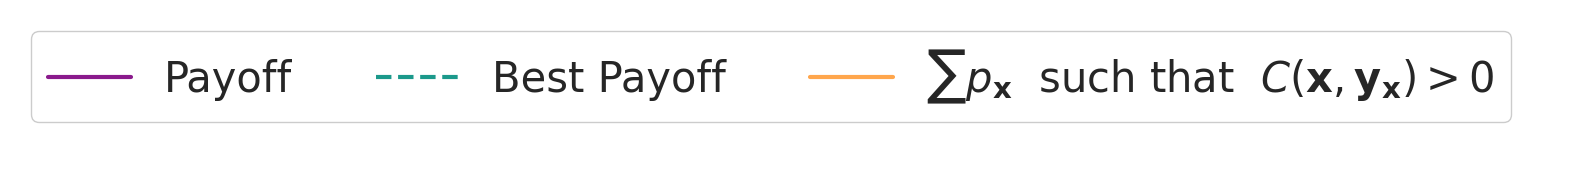

In [8]:
fig = plt.figure(figsize=(20, 2))
plt.axis('off')  # Remove axis lines and ticks
plt.xticks([])  # Remove x-ticks
plt.yticks([])  # Remove y-ticks
plt.grid(False)
custom_lines = [
    Line2D([0], [0], color=main_c, lw=3),
    Line2D([0], [0], linestyle="--", color=second_c, lw=3),
    Line2D([0], [0], color=third_c, lw=3)
]
plt.legend(custom_lines,
           ['Payoff', 'Best Payoff',
            r'$\sum p_{\mathbf{x}}$  such that  $C(\mathbf{x},\mathbf{y_x})>0$'],
           loc="upper left",
           ncol=3,
           framealpha=1, fontsize=30)
fig.patch.set_alpha(0)
plt.savefig(
    res_path / f"optimization_loss_paper_legend.png", dpi=1200)
#plt.show()

In [ ]:
df_concat = pd.concat(
    [QUEEN_it_df, EAGLE_it_df, EAGLE_H_it_df, HERON_it_df, HERON_H_it_df],
    axis=0)
vals = []
for f in df_concat["file"].unique():
    with open(res_path / Path(f) / "config.json", "r") as f:
        config = json.load(f)
    dsr_config = deserialize_json(config, base="")
    vals.append(
        [
            config_check(dsr_config, "opt_mode"),
            config_check(dsr_config, "instance")[:6],
            config_check(dsr_config,
                         "opt_options_primitive_options_backend_options_name"),
            config_check(dsr_config, "opt_options_ansatz"),
            config_check(dsr_config, "opt_options_shots"),
            config_check(dsr_config, "opt_options_minimizer"),
            config_check(dsr_config, "opt_options_minimizer_options_maxiter"),
            config_check(dsr_config, "opt_options_minimizer_options_sd")[:7],
            "-" != config_check(dsr_config,
                                "opt_options_primitive_options_mitigation_options_dd_sequence_type"),
            config_check(dsr_config,
                         "opt_options_primitive_options_mitigation_options_dd_sequence_type"),
            "-" != config_check(dsr_config,
                                "opt_options_primitive_options_mitigation_options_rem_hammer_max_hd"),
        ]
    )

config_df = pd.DataFrame(
    vals,
    columns=[
        "Solver",
        "Instance",
        "Backend",
        "Ansatz",
        "Shots",
        "Optimizer",
        "Iterations",
        "Std. Dev.",
        "DD",
        "DD Sequence",
        "iHAMMER"
    ]
)
mbd_tmp_df = config_df.drop_duplicates().sort_values(by="Instance", ascending=True)

f_dict = {}
values = [
        "Instance",
        "Backend",
        "Ansatz",
        "Shots",
        "Optimizer",
        "Iterations",
        "Std. Dev.",
        "DD",
        "DD Sequence",
        "iHAMMER"
    ]
for n, row in mbd_tmp_df.iterrows():
    key = f"{row['Solver']}_{n}"
    f_dict[key] = row[values]

f_df = pd.DataFrame(f_dict)
print(f_df.to_latex())

\begin{tabular}{llllll}
\toprule
 & QUEEN_0 & MBD_5 & MBD_10 & MBD_15 & MBD_16 \\
\midrule
Instance & gs\_20 & gs\_20 & gs\_20 & gs\_20 & gs\_20 \\
Backend & - & ibm\_brisbane & ibm\_brisbane & ibm\_fez & ibm\_fez \\
Ansatz & rotations & hardware\_efficient & hardware\_efficient & hardware\_efficient & hardware\_efficient \\
Shots & 2000 & 2000 & 2000 & 2000 & 2000 \\
Optimizer & BAYESIAN & BAYESIAN & BAYESIAN & BAYESIAN & BAYESIAN \\
Iterations & 100 & 100 & 100 & 100 & 100 \\
Std. Dev. & 0.14361 & 0.14361 & 0.14361 & 0.14361 & 0.14361 \\
DD & False & True & True & True & True \\
DD Sequence & - & XpXm & XpXm & XpXm & XpXm \\
iHAMMER & False & False & True & False & True \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
QUEEN_0 & MBD_5 & MBD_10 & MBD_15 & MBD_16 \\
\midrule
gs\_20 & gs\_20 & gs\_20 & gs\_20 & gs\_20 \\
- & ibm\_brisbane & ibm\_brisbane & ibm\_fez & ibm\_fez \\
rotations & hardware\_efficient & hardware\_efficient & hardware\_efficient & hardware\_efficient

## Run plot

In [6]:
iterations_df.drop("Unnamed: 0", axis=1)

,file,backend_name,optimizer,shots,circuit,qubits,repetition,iteration,explored_states,relevant_states,...,raw_counts,hammered_count,q_time,circuit_depth,cplex_payoff,cplex_solution,minimizer,minimizer_params,old_params,new_params
0,gs_40_13/quantum_2024-09-18_21-17-25,-,QUEEN,10000,rotations,40,13,0,1,1,...,0,1,-1.0,-1,0.703248,[1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0...,BAYESIAN,ucb (2.576),0.8807364159026386 0.6148064601135969 0.800889...,1.4021116799378675e-05 1.1914769171283979e-09 ...
1,gs_40_13/quantum_2024-09-18_21-17-25,-,QUEEN,10000,rotations,40,13,1,51,50,...,0,50,-1.0,-1,0.703248,[1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0...,BAYESIAN,ucb (2.576),3.01622539790388 1.4609497980729844 2.76909471...,3.141592653589793 0.7532584682423318 3.1415926...
2,gs_40_13/quantum_2024-09-18_21-17-25,-,QUEEN,10000,rotations,40,13,2,115,64,...,0,64,-1.0,-1,0.703248,[1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0...,BAYESIAN,ucb (2.576),1.165544998253309 2.4436164308205415 0.0107297...,0.014286425227528543 3.1415926232519107 0.0 2....
3,gs_40_13/quantum_2024-09-18_21-17-25,-,QUEEN,10000,rotations,40,13,3,161,46,...,0,46,-1.0,-1,0.703248,[1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0...,BAYESIAN,ucb (2.576),0.6257315536468225 2.719910202924486 2.6470777...,1.8522130496023692e-09 3.1415926535895737 3.14...
4,gs_40_13/quantum_2024-09-18_21-17-25,-,QUEEN,10000,rotations,40,13,4,163,3,...,0,3,-1.0,-1,0.703248,[1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0...,BAYESIAN,ucb (2.576),1.182062872203081 0.7689107316828081 0.3253098...,0.019390610641862205 3.8489782450135124e-07 1....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212879,gs_20_0/quantum_2024-10-22_12-00-50,-,MBD,2000,hardware_efficient,20,0,96,23557,276,...,0,276,-1.0,-1,0.999974,[1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1],BAYESIAN,ei (0.75),3.1371505894427734 0.8045592565254754 0.660189...,3.141592653589793 1.4976055373594477e-07 3.594...
212880,gs_20_0/quantum_2024-10-22_12-00-50,-,MBD,2000,hardware_efficient,20,0,97,23912,359,...,0,359,-1.0,-1,0.999974,[1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1],BAYESIAN,ei (0.75),2.5833299752211296 0.4723212317973608 3.110870...,3.14159265358699 3.219646771412954e-14 3.14159...
212881,gs_20_0/quantum_2024-10-22_12-00-50,-,MBD,2000,hardware_efficient,20,0,98,24325,425,...,0,425,-1.0,-1,0.999974,[1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1],BAYESIAN,ei (0.75),1.6240161368362465 1.469232879263864 0.3013573...,2.024828597343588 0.7531091901214366 0.0 3.141...
212882,gs_20_0/quantum_2024-10-22_12-00-50,-,MBD,2000,hardware_efficient,20,0,99,24551,235,...,0,235,-1.0,-1,0.999974,[1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1],BAYESIAN,ei (0.75),1.4239746351371956 1.5313973354421122 0.586146...,0.48164159028101494 1.2312277444424349 1.11066...


In [7]:
# Clear data for re-computation
file_name = "gs_20_0/quantum_2024-10-22_12-00-53"
not_file_df = iterations_df[iterations_df["file"] != file_name]
not_file_df.to_csv(res_path / "iterations_df.csv")
iterations_df = load_iterations_df(res_path, compute=True)

Elaborating results in gs_40_13 - 0/329
Elaborating results in gs_35_41 - 1/329
Elaborating results in gs_20_14 - 2/329
Elaborating results in gs_35_44 - 3/329
Elaborating results in gs_50_33 - 4/329
Elaborating results in gs_35_47 - 5/329
Elaborating results in gs_50_25 - 7/329
Elaborating results in gs_50_4 - 8/329
Elaborating results in gs_35_33 - 9/329
Elaborating results in gs_25_6 - 10/329
Elaborating results in gs_30_12 - 11/329
Elaborating results in gs_30_37 - 12/329
Elaborating results in gs_35_21 - 13/329
Elaborating results in gs_35_6 - 14/329
Elaborating results in gs_40_10 - 15/329
Elaborating results in gs_20_47 - 16/329
Elaborating results in gs_30_7 - 17/329
Elaborating results in gs_30_21 - 18/329
Elaborating results in gs_20_33 - 19/329
Elaborating results in gs_30_13 - 20/329
Elaborating results in gs_35_18 - 21/329
Elaborating results in gs_35_3 - 22/329
Elaborating results in gs_30_23 - 24/329
Elaborating results in gs_30_16 - 25/329
Elaborating results in gs_25_2

In [8]:
unique_files = iterations_df["file"].unique()
params_dict = get_params_dict(res_path, unique_files)
rep = file_name.split("/")[0].split("_")[2]
size = file_name.split("/")[0].split("_")[1]
file_df = iterations_df[iterations_df["file"] == file_name]
df_sorted = file_df.sort_values(by='iteration')
evs = df_sorted['payoff'].tolist()
bests = (-df_sorted['payoff_best']).tolist()
valids = [int(v) if v != "[]" and int(v) >= 0 else 0 for v in
          df_sorted['valid_states'].tolist()]
valids_color = [
    "violet" if row["max_sample_payoff"] != -row["payoff_best"] else "green"
    for n, row in df_sorted.iterrows()]
valids_probs = [float(v) if v != "[]" else 0 for v in
                df_sorted['valid_states_probs'].tolist()]
optimizer = file_df["optimizer"].unique()[0]
h = "_HAMMER" if all(file_df["raw_counts"]) >= 1 else ""

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 16), gridspec_kw={
    'height_ratios': [5, 1, 1, 1]}, sharex=True)

ax2.bar(range(len(evs)), valids, color=valids_color, alpha=1)
ax2.set_ylim(0, max(valids) + 1)
ax2.set_yscale("symlog", linthresh=10 ** 0)
ax2.set_ylabel("Valid Counts")
violet_square = mpatches.Patch(color='violet',
                               label='Valid Soltions Counts')
ax2.legend(handles=[violet_square], loc="upper left")

ax3.plot(range(len(evs)), valids_probs, color='orange', alpha=1,
         label='Valid Cumulative Probability')
ax3.set_ylim(0, 1.5)
ax3.set_yscale("symlog", linthresh=2 ** -4, base=2)
ax3.set_ylabel("Probability")
ax3.legend(loc="upper left")

num_iterations = len(evs)
heatmap_data = get_cluster(file_df["old_params"], int(len(file_df) / 10))
cax = ax4.imshow(heatmap_data, aspect='auto', cmap='viridis',
                 interpolation='nearest')
fig.colorbar(cax, ax=ax4, orientation='horizontal', pad=0.38,
             label='Heatmap Value')
ax4.set_xlabel("Iterations")
ax4.set_yticks([])
ax4.set_xlim(min(file_df["iteration"]), max(file_df["iteration"]))
ax1.hlines(0, 0, len(evs),
           linestyles=":", color="green", label="Validity Threshold")
ax1.hlines(max(file_df["cplex_payoff"]), 0, len(evs),
           linestyles=":", color="orange", label="Optimal Payoff")
ax1.set_ylim(min(evs), 10)
ax1.set_yscale("symlog", linthresh=10 ** 0)
ax1.plot(range(len(evs)), evs, label="Point Evaluation")
ax1.plot(range(len(evs)), bests, linestyle="--", label="Best Solution")
ax1.set_ylabel("Payoff")
ax1.legend(loc="upper left")
plt.tight_layout()
plt.savefig(
    res_path / file_name / f"optimization_loss_{size}_{rep}_{optimizer}_{params_dict[file_name]}_{h}.pdf")
plt.close("all")
gc.collect()

101372

# Stats 

In [25]:
from modules.ntsp.loader import Loader

data_path = root_path / "modules/ntsp/data"
vals = []
for gs in data_path.iterdir():
    if "gs" not in gs.name:
        continue
    instance = Loader("json").load(gs.name)
    size = len(instance.t_cash_amounts())
    opt_p = None
    set_perc = None
    classical_results = res_path / f"{gs.name.split('.')[0]}_0"
    if classical_results.exists():
        for p in classical_results.iterdir():
            if "classical" in p.name:
                with open(p / "results.json", "r") as f:
                    r = json.load(f)
        opt_p = r["evaluation"]
        set_perc = int(100 * sum(
            [1 for c in r["transactions"] if c == 1 or c == "1"]) / size)
    if set_perc is None:
        continue
    vals.append(
        [
            gs.name.split(".")[0],
            size,
            len(instance.cb_balances()),
            len(instance.sp_quantities()),
            len(instance.s_prices()),
            len(instance.links_first()),
            opt_p,
            f"{set_perc} %"
        ]
    )
data_df = pd.DataFrame(vals, columns=[
    "Name",
    "# Transactions",
    "# CB",
    "# SP",
    "# Securities",
    "# After Links",
    "Optimal Payoff",
    "Settled Transactions"
])
data_df.sort_values(by="# Transactions", ascending=True, inplace=True)
print(data_df.to_latex(index=False, float_format="%.3f"))

\begin{tabular}{lrrrrrll}
\toprule
Name & # Transactions & # CB & # SP & # Securities & # After Links & Optimal Payoff & Settled Transactions \\
\midrule
gs_20 & 20 & 12 & 25 & 3 & 6 & 0.9999744323154514 & 70 % \\
gs_25 & 25 & 13 & 27 & 3 & 8 & 0.805753878781436 & 76 % \\
gs_30 & 30 & 14 & 34 & 3 & 9 & 0.9999833373168395 & 66 % \\
gs_35 & 35 & 19 & 38 & 3 & 11 & 0.8269211428657245 & 77 % \\
gs_40 & 40 & 17 & 45 & 4 & 9 & 0.7032478198878831 & 60 % \\
gs_50 & 50 & 18 & 55 & 5 & 9 & 0.7267514997381955 & 60 % \\
\bottomrule
\end{tabular}

